In [1]:
import pandas as pd
import geopandas as gpd

from fiona.crs import from_epsg
from shapely.geometry import Point

from pprint import pprint

import requests
import re

from cidr import * # My functions for ARIN calls.

In [2]:
from shapely.geometry import box
cut_ohare = box(339000, 370000, 500000, 700000)

chicago = gpd.read_file("chicago.geojson").to_crs(epsg = 3528)
chicago.set_geometry(chicago.intersection(cut_ohare), inplace = True)
chicago_shape = chicago.geometry.iloc[0]

In [3]:
ip = pd.read_csv("/media/jsaxon/brobdingnag/data/corona/ip/chicago_xy.csv.bz2", 
                 names = ["id", "datetime", "x", "y", "ip"], nrows = 10000000)

### Focus on the South Side for the moment??

In [4]:
xmin_SS, xmax_SS = 355000, 365000
ymin_SS, ymax_SS = 564500, 575000

In [5]:
# ip.query("({} < x) & (x < {}) & ({} < y) & (y < {})".format(xmin_SS, xmax_SS, ymin_SS, ymax_SS), inplace = True)
# ip.shape[0]

### Have a look-see...

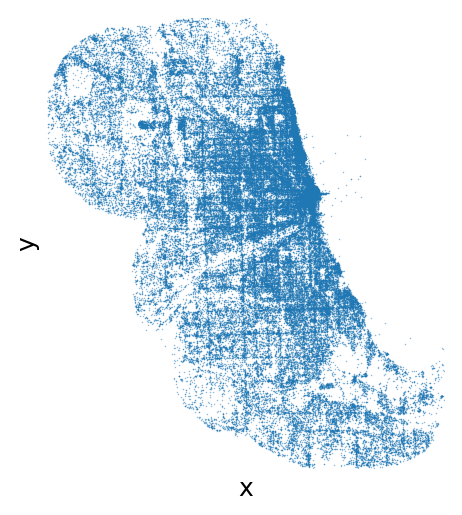

In [6]:
fig, ax = plt.subplots(subplot_kw = {"aspect" : 1}, figsize = (3, 3))
ip[:100000].plot(kind = "scatter", x = "x", y = "y", s = 0.5, alpha = 0.5, linewidth = 0, ax = ax)

map_format(ax)

### Pull out IPv4 and IPv6 subnets.

In [7]:
ip["subnet"] = ip.ip.str.replace("\.\d+$", "", regex = True)
ip["subnet"] = ip.subnet.str.replace(r"^([0-9,A-F]+:[0-9,A-F]*):+.*", r"\1:", regex = True)

### Create a list of all subnets with at least 50 locations and 5 users.

In [8]:
sn_list = ip.groupby("subnet").agg({"id" : pd.Series.nunique, "subnet" : "count"})\
            .rename(columns = {"id" : "users", "subnet" : "nlocations"}).reset_index()

sn_list.query("(users > 5) & (nlocations > 50)", inplace = True)

### Retrieve address blocks from ARIN, so we can focus on one provider at a time.

(See cidr.py for the API calls and ipaddress stuff.)

### Apply the look-up, caching results as we go.

In [9]:
sn_list["CIDR"] = sn_list.subnet.apply(find_cidr)
sn_list = sn_list.merge(cidr_df, how = "left")

cache_cidr() # save any new subnets

In [10]:
sn_list = sn_list.query("DBA != 'IANA'").dropna().copy() # local admin use...

### Merge the subnet look-ups with the addresses.

Note that this is implicitly dropping subnets with less than 50 observations, which is what I put into the subnet list and retrieved from ARIN.

In [11]:
ip = ip.merge(sn_list[["subnet", "DBA"]], how = "inner")

In [12]:
comcast = ip[ip.DBA == "Comcast"].copy()
comcast["cnet"] = pd.Categorical(comcast["subnet"], ordered = True)

comcast.reset_index(drop = True, inplace = True)

comcast_geo = gpd.GeoSeries([Point(xy) for xy in comcast[["x", "y"]].values],
                            crs = from_epsg(3528), index = comcast.index)

comcast = gpd.GeoDataFrame(data = comcast, geometry = comcast_geo, crs = comcast_geo.crs)

comcast["chicago"] = comcast.within(chicago_shape)

In [13]:
comcast_SS = comcast[(xmin_SS < comcast.x) & (comcast.x < xmax_SS) & \
                     (ymin_SS < comcast.y) & (comcast.y < ymax_SS)].copy()

common = set(sn_list.query("(users > 5) & (nlocations > 50)").subnet.unique())

comcast_SS = comcast_SS.loc[comcast_SS.subnet.isin(common)]

comcast_SS["cnet"] = pd.Categorical(comcast_SS["subnet"], ordered = True)

comcast_SS.reset_index(drop = True, inplace = True)

In [14]:
streets = gpd.read_file("/media/jsaxon/brobdingnag/projects/broadband/streets_lw.geojson")

### Forget about the legend...

In [15]:
len(common)

9803

In [16]:
comcast_SS.shape

(173290, 10)

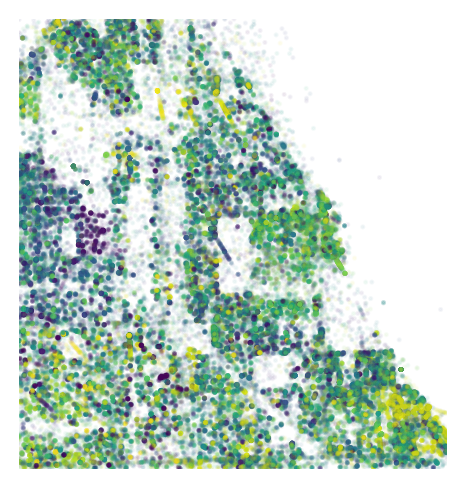

In [17]:
fig, ax = plt.subplots(figsize = (3, 3))

V = comcast_SS.plot(column = "subnet", cmap = "viridis", categorical = True, 
                    alpha = 0.05, markersize = 2, legend = False, ax = ax)

streets.plot(lw = streets.highway_thickness / 5, 
             alpha = 0.025, color = "w", zorder = 10, ax = ax)

ax.set_xlim(xmin_SS, xmax_SS)
ax.set_ylim(ymin_SS, ymax_SS)

map_format(ax)

In [18]:
def plot_network(subnet, users, locations):

    fig, ax = plt.subplots(figsize = (4, 4))

    c = comcast.query("chicago & (subnet == '{:s}')".format(subnet))
    c.plot(ax = ax, markersize = 2, alpha = min(1, 1000 / c.shape[0]), lw = 0, color = "r")

    chicago.plot(edgecolor = "#8888FF", color = "none", lw = 1, ax = ax, zorder = -10)
        
    map_format(ax)
    
    # ax.set_xlim(xmin_SS, xmax_SS)
    # ax.set_ylim(ymin_SS, ymax_SS)

    text_kw = {"x" : 0.78, "horizontalalignment" : 'center'}
    
    fig.text(y = 0.910, s = subnet, fontsize=12, **text_kw, fontweight = "semibold")
    fig.text(y = 0.850, s = "{} users".format(users), fontsize=10, **text_kw)
    fig.text(y = 0.805, s = "{} locations".format(locations), fontsize=10, **text_kw)
    
    fig.savefig("figs/" + subnet + ".pdf")
    
    plt.close("all")

In [19]:
sn_list_CSS = comcast_SS.groupby("subnet").agg({"id" : pd.Series.nunique, "subnet" : "count"})\
                        .rename(columns = {"id" : "users", "subnet" : "nlocations"}).reset_index()

sn_list_CSS.sort_values(["users", "nlocations"], ascending = [False, False], inplace = True)

In [20]:
for ri, row in sn_list_CSS[:50].iterrows():
    print(row["subnet"], row["users"], row["nlocations"])
    plot_network(row["subnet"], row["users"], row["nlocations"])

73.110.42 2030 5419
73.110.46 1735 4313
73.110.45 1704 4173
73.110.41 1493 3311
2601:240: 224 2272
73.110.47 124 176
73.9.19 123 725
98.222.252 116 516
24.12.172 114 609
71.57.71 113 711
71.57.84 112 591
67.186.64 112 540
24.12.101 112 499
73.9.17 111 754
24.13.160 111 693
73.36.2 111 147
67.186.65 108 414
71.57.1 106 632
71.57.69 105 802
73.44.7 104 630
73.209.158 103 938
73.44.1 102 556
98.253.100 101 741
67.176.179 101 547
24.12.120 100 635
73.44.31 99 250
24.13.170 98 577
71.57.70 98 546
67.175.74 98 461
24.12.121 97 642
73.44.0 96 661
73.9.18 96 435
67.176.178 95 512
67.176.214 95 484
98.222.254 95 435
73.9.16 95 397
67.176.213 94 851
73.168.48 94 653
73.208.44 94 580
73.50.209 94 492
73.50.211 93 676
67.162.3 92 609
73.45.77 92 583
24.1.165 92 466
73.44.4 92 405
67.175.75 91 645
24.13.118 91 628
71.57.68 91 495
73.22.59 91 439
98.227.157 91 384


✔ Check how many users are on each subnet...
* Load in ALL of the data.
* Only allow devices to define their own home location?